In [4]:
# import modules/downloads

import pandas as pd
import re
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim.corpora as corpora

from pprint import pprint

import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

import os


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shraeya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# load test data files

test_set = pd.read_csv("test.txt", sep=";")
train_set = pd.read_csv("train.txt", sep=";")
val_set = pd.read_csv("val.txt", sep=";")
val_set.columns = ["text","sentiment"]
val_set.head()


,text,sentiment
0,i feel like i am still looking at a blank canv...,sadness
1,i feel like a faithful servant,love
2,i am just feeling cranky and blue,anger
3,i can have for a treat or if i am feeling festive,joy
4,i start to feel more appreciative of what god ...,joy


In [6]:
# Data cleaning/preprocessing

# Remove punctuation
val_set['text'] = \
val_set['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Make titles lowercase
val_set['text'] = \
val_set['text'].map(lambda x: x.lower())

# first rows of text
val_set['text'].head()


<>:5: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \.
/var/folders/rd/4d6wd0gx3zjctb1dgrg64fgw0000gn/T/ipykernel_90484/3975563116.py:5: DeprecationWarning: invalid escape sequence \.
  val_set['text'].map(lambda x: re.sub('[,\.!?]', '', x))


0    i feel like i am still looking at a blank canv...
1                       i feel like a faithful servant
2                    i am just feeling cranky and blue
3    i can have for a treat or if i am feeling festive
4    i start to feel more appreciative of what god ...
Name: text, dtype: object

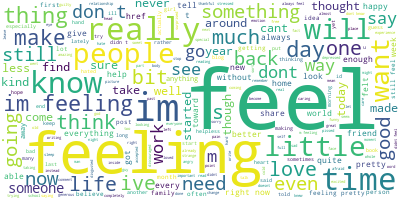

In [7]:
# visual wordcloud exploratory analysis

# Join processed titles
joined_titles = ','.join(list(val_set['text'].values))

# WordCloud object
word_cloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# show word cloud
word_cloud.generate(joined_titles)
word_cloud.to_image()


In [8]:
#transform text data to useful training LDA model input

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'feel', 'feeling', 'really'])

def tokenize_text(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # remove punctuations
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = val_set.text.values.tolist()
tokenized_words = list(tokenize_text(data))

tokenized_words = remove_stopwords(tokenized_words)
print(tokenized_words[:1][0][:10])


['like', 'still', 'looking', 'blank', 'canvas', 'blank', 'pieces', 'paper']


In [9]:
# convert tokenized object into a corpus and dictionary

# Dictionary
id2word = corpora.Dictionary(tokenized_words)
# Corpus
texts = tokenized_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:10])


[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [10]:
# build model with 6 topics (main emotions)

# number of topics
num_topics = 6

lda_mod = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print Keyword in topics
pprint(lda_mod.print_topics())
doc_lda = lda_mod[corpus]


[(0,
  '0.023*"like" + 0.011*"little" + 0.009*"im" + 0.007*"would" + 0.006*"help" + '
  '0.005*"want" + 0.005*"people" + 0.005*"make" + 0.005*"ive" + 0.005*"even"'),
 (1,
  '0.023*"im" + 0.017*"like" + 0.009*"know" + 0.008*"get" + 0.006*"something" '
  '+ 0.006*"love" + 0.006*"people" + 0.006*"even" + 0.005*"still" + '
  '0.005*"one"'),
 (2,
  '0.020*"im" + 0.017*"like" + 0.010*"know" + 0.007*"going" + 0.005*"always" + '
  '0.005*"want" + 0.004*"back" + 0.004*"dont" + 0.004*"would" + 0.004*"one"'),
 (3,
  '0.018*"im" + 0.016*"like" + 0.007*"day" + 0.007*"get" + 0.006*"good" + '
  '0.005*"people" + 0.005*"love" + 0.005*"life" + 0.004*"ive" + 0.004*"even"'),
 (4,
  '0.013*"time" + 0.011*"im" + 0.009*"like" + 0.007*"know" + 0.005*"need" + '
  '0.005*"made" + 0.005*"little" + 0.005*"things" + 0.004*"life" + '
  '0.004*"today"'),
 (5,
  '0.012*"like" + 0.008*"pretty" + 0.007*"time" + 0.006*"still" + 0.005*"ive" '
  '+ 0.005*"im" + 0.005*"want" + 0.005*"href" + 0.005*"http" + '
  '0.004*"som

In [11]:
# Visualize the topics
cwd = os.getcwd()
directory = os.path.join(cwd, 'results/lda_vis_'+str(num_topics))
if not os.path.exists(directory):
    os.makedirs(directory)

pyLDAvis.enable_notebook()
LDAvis_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

if 1 == 1:
    LDA_vis = pyLDAvis.gensim_models.prepare(lda_mod, corpus, id2word)
    with open(LDAvis_filepath, 'wb') as f:
        pickle.dump(LDA_vis, f)

# load pyLDAvis data from disk
with open(LDAvis_filepath, 'rb') as f:
    LDA_vis = pickle.load(f)
pyLDAvis.save_html(LDA_vis, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDA_vis

/Users/shraeya/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/shraeya/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shraeya/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shraeya/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/shraeya/opt/anaconda3/lib/p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.056279  0.046417       1        1  22.260469
3     -0.034550  0.005372       2        1  17.859067
0     -0.029211 -0.018495       3        1  17.672008
2     -0.028128  0.010672       4        1  16.546269
4      0.037126 -0.100654       5        1  13.898949
5      0.111042  0.056688       6        1  11.763239, topic_info=          Term        Freq       Total Category  logprob  loglift
101       time   76.000000   76.000000  Default  30.0000  30.0000
367     pretty   41.000000   41.000000  Default  29.0000  29.0000
438       help   27.000000   27.000000  Default  28.0000  28.0000
274       need   38.000000   38.000000  Default  27.0000  27.0000
106         im  248.000000  248.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
333      makes    3.930450   17.969138   Topic6  -6.1846   0.6203
219     people    5.051667   70.580938   Topic6  -5.9337  -0.4969
295        see    4.306238   32.258621   Topic6  -6.0933   0.1265
122  something    4.608389   49.639630   Topic6  -6.0255  -0.2367
174       kind    3.988651   23.853484   Topic6  -6.1699   0.3517

[478 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1958      6  0.881033          abit
1981      3  0.871534  accomplished
127       1  0.424604      actually
127       2  0.121315      actually
127       3  0.121315      actually
...     ...       ...           ...
881       6  0.162899         write
363       3  0.131992           www
363       4  0.263984           www
363       6  0.659959           www
1628      5  0.661355          yoga

[994 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3, 5, 6])